In [113]:
import pandas as pd
import numpy as np
from datetime import datetime
import calendar
import matplotlib.pyplot as plt
import yfinance as yf
from functions import functions
import scipy
from IPython.display import display, HTML
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from fredapi import Fred

%reload_ext autoreload
%autoreload 2
%matplotlib inline

spy = yf.download("SPY", start = "2000-01-01", end = datetime.today().strftime("%Y-%m-%d"))
fred_api = '3040e25eb696826211b7ea235504a8ae'
fred = Fred(api_key=fred_api)

[*********************100%%**********************]  1 of 1 completed


#### Trend Following

In [89]:
trend_following_sig = spy.loc[:'2010-12-31'].copy()
trend_following_sig

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,148.250000,148.250000,143.875000,145.437500,94.262611,8164300
2000-01-04,143.531250,144.062500,139.640625,139.750000,90.576332,8089800
2000-01-05,139.937500,141.531250,137.250000,140.000000,90.738358,12177900
2000-01-06,139.625000,141.500000,137.750000,137.750000,89.280052,6227200
2000-01-07,140.312500,145.750000,140.062500,145.750000,94.465080,8066500
...,...,...,...,...,...,...
2010-12-27,125.129997,125.769997,125.040001,125.650002,98.897491,58126000
2010-12-28,125.900002,125.949997,125.500000,125.830002,99.039154,55309100
2010-12-29,125.980003,126.199997,125.900002,125.919998,99.109993,58033100


Text(0.5, 0.98, 'Trend Following (50DMA)')

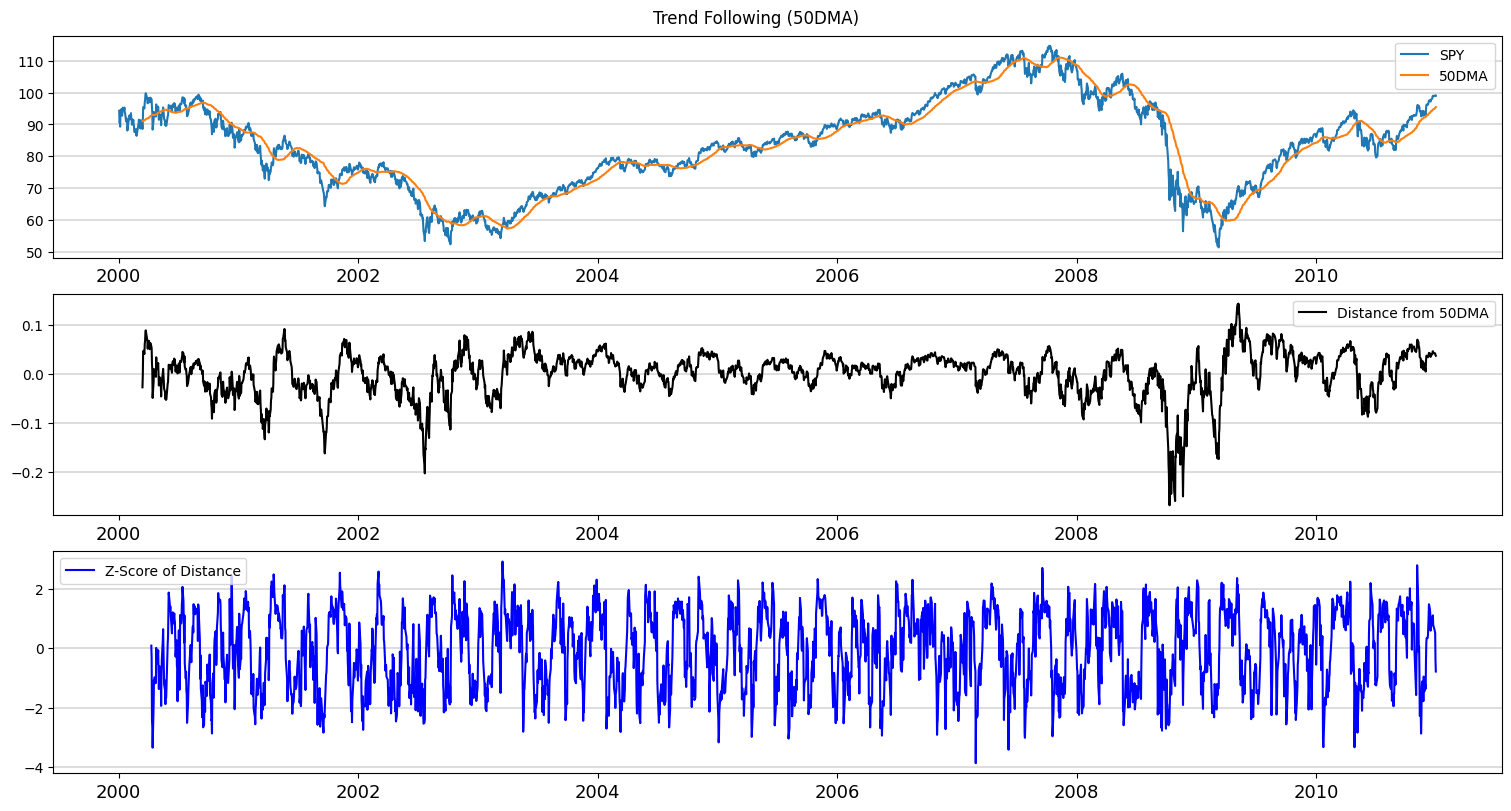

In [90]:
trend_following_sig["50DMA"] = trend_following_sig[["Adj Close"]].rolling(50).mean()
trend_following_sig["dist_50dma"] = (trend_following_sig["Adj Close"] / trend_following_sig["50DMA"])  - 1
z_50dma_dist_obj = trend_following_sig["dist_50dma"].rolling(20)
z_50dma_dist_z = (trend_following_sig["dist_50dma"] - z_50dma_dist_obj.mean()) / z_50dma_dist_obj.std()

fig, ax = plt.subplots(3, 1, figsize = (15, 8), constrained_layout = True, sharex = True)

ax[0].plot(trend_following_sig["Adj Close"], label = "SPY")
ax[0].plot(trend_following_sig["50DMA"], label = "50DMA")
ax[0].grid(axis='y', linewidth=1.2, alpha=0.5)
ax[0].legend()
ax[0].xaxis.set_tick_params(which='both', labelbottom=True, labelsize=13)
ax[1].plot(trend_following_sig["dist_50dma"], label = "Distance from 50DMA", color = "black")
ax[1].grid(axis='y', linewidth=1.2, alpha=0.5)
ax[1].legend()
ax[1].xaxis.set_tick_params(which='both', labelbottom=True, labelsize=13)
ax[2].plot(z_50dma_dist_z, label = "Z-Score of Distance", color = "blue")
ax[2].grid(axis='y', linewidth=1.2, alpha=0.5)
ax[2].legend()
ax[2].xaxis.set_tick_params(which='both', labelbottom=True, labelsize=13)
fig.suptitle("Trend Following (50DMA)")

Text(0.5, 0.98, 'Trend Following (200DMA)')

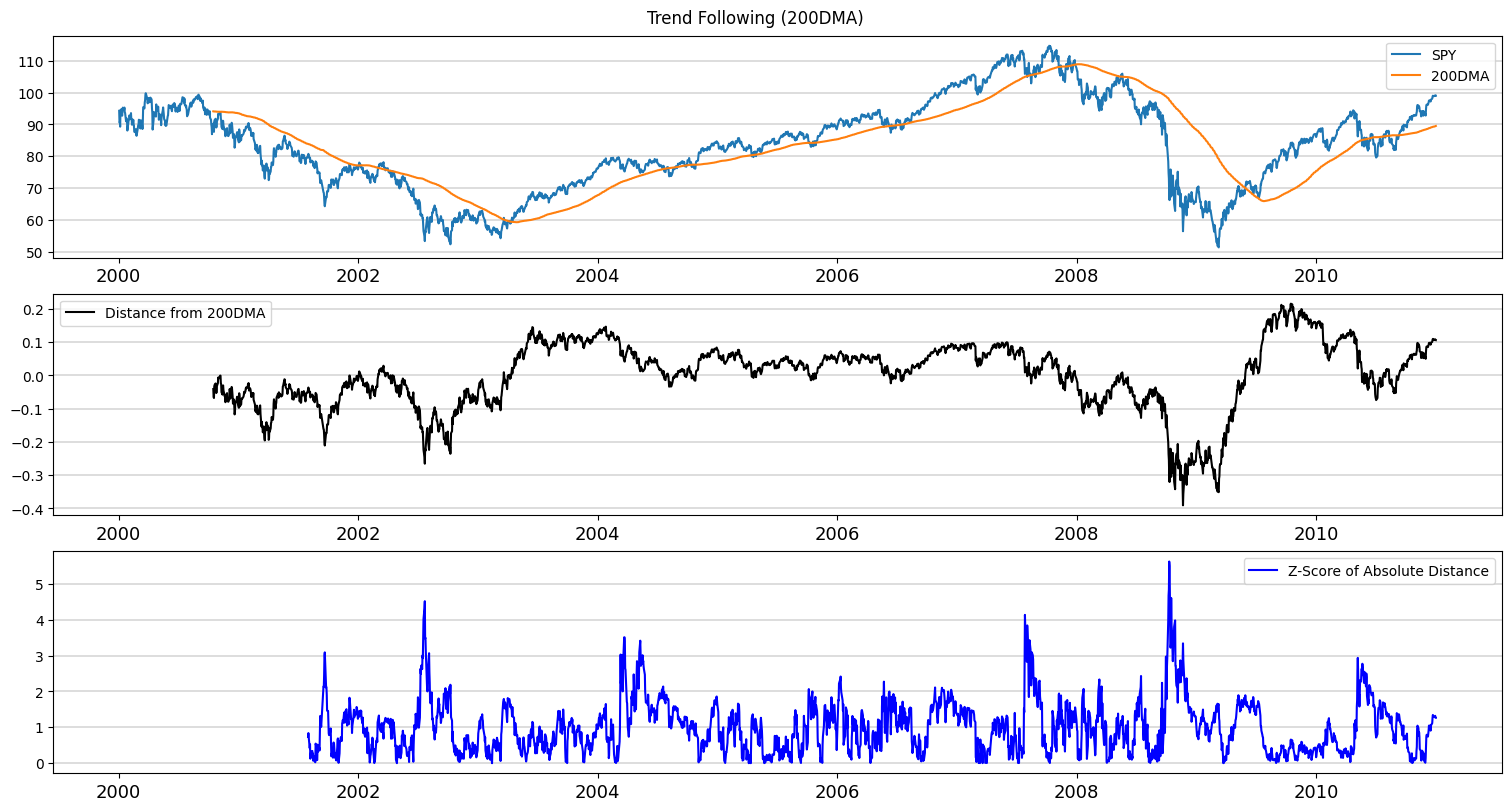

In [97]:
trend_following_sig["200DMA"] = trend_following_sig[["Adj Close"]].rolling(200).mean()
trend_following_sig["dist_200dma"] = (trend_following_sig["Adj Close"] / trend_following_sig["200DMA"])  - 1
z_200dma_dist_obj = trend_following_sig["dist_200dma"].abs().rolling(200)
trend_following_sig["Z"] = (trend_following_sig["dist_200dma"].abs() - z_200dma_dist_obj.mean()) / z_200dma_dist_obj.std()

# Create signal
trend_following_sig["Direction"] = np.where(trend_following_sig.dist_200dma >= 0, 1, -1)
trend_following_sig["Direction_Adj"] = trend_following_sig["Direction"].shift(1)

fig, ax = plt.subplots(3, 1, figsize = (15, 8), constrained_layout = True, sharex = True)

ax[0].plot(trend_following_sig["Adj Close"], label = "SPY")
ax[0].plot(trend_following_sig["200DMA"], label = "200DMA")
ax[0].grid(axis='y', linewidth=1.2, alpha=0.5)
ax[0].legend()
ax[0].xaxis.set_tick_params(which='both', labelbottom=True, labelsize=13)
ax[1].plot(trend_following_sig["dist_200dma"], label = "Distance from 200DMA", color = "black")
ax[1].grid(axis='y', linewidth=1.2, alpha=0.5)
ax[1].legend()
ax[1].xaxis.set_tick_params(which='both', labelbottom=True, labelsize=13)

ax[2].plot(trend_following_sig.Z.abs(), label = "Z-Score of Absolute Distance", color = "blue")
# ax[2].plot(trend_following_sig.Size, label = "Position Sizing", linestyle = "dotted", color = "red")
ax[2].grid(axis='y', linewidth=1.2, alpha=0.5)
ax[2].legend()
ax[2].xaxis.set_tick_params(which='both', labelbottom=True, labelsize=13)
fig.suptitle("Trend Following (200DMA)")

In [108]:
trend_following_strat = (trend_following_sig["Direction_Adj"] * trend_following_sig["Adj Close"].pct_change()).dropna()
trend_following_strat.name = "Trend_Fol"

In [109]:
functions.exportPerformanceMetrics(trend_following_strat, trend_following_sig["Adj Close"].pct_change().dropna())

,Strategy,Benchmark
Performance Metrics (2000-01-04 till 2010-12-31),,
CAGR %,1.61%,0.45%
Volatility,22.07%,22.07%
Sharpe Ratio,0.07,0.02
Sortino Ratio,0.09,0.03
Max Drawdown %,-35.19%,-55.19%
Return/MaxDrawdown,0.05,0.01


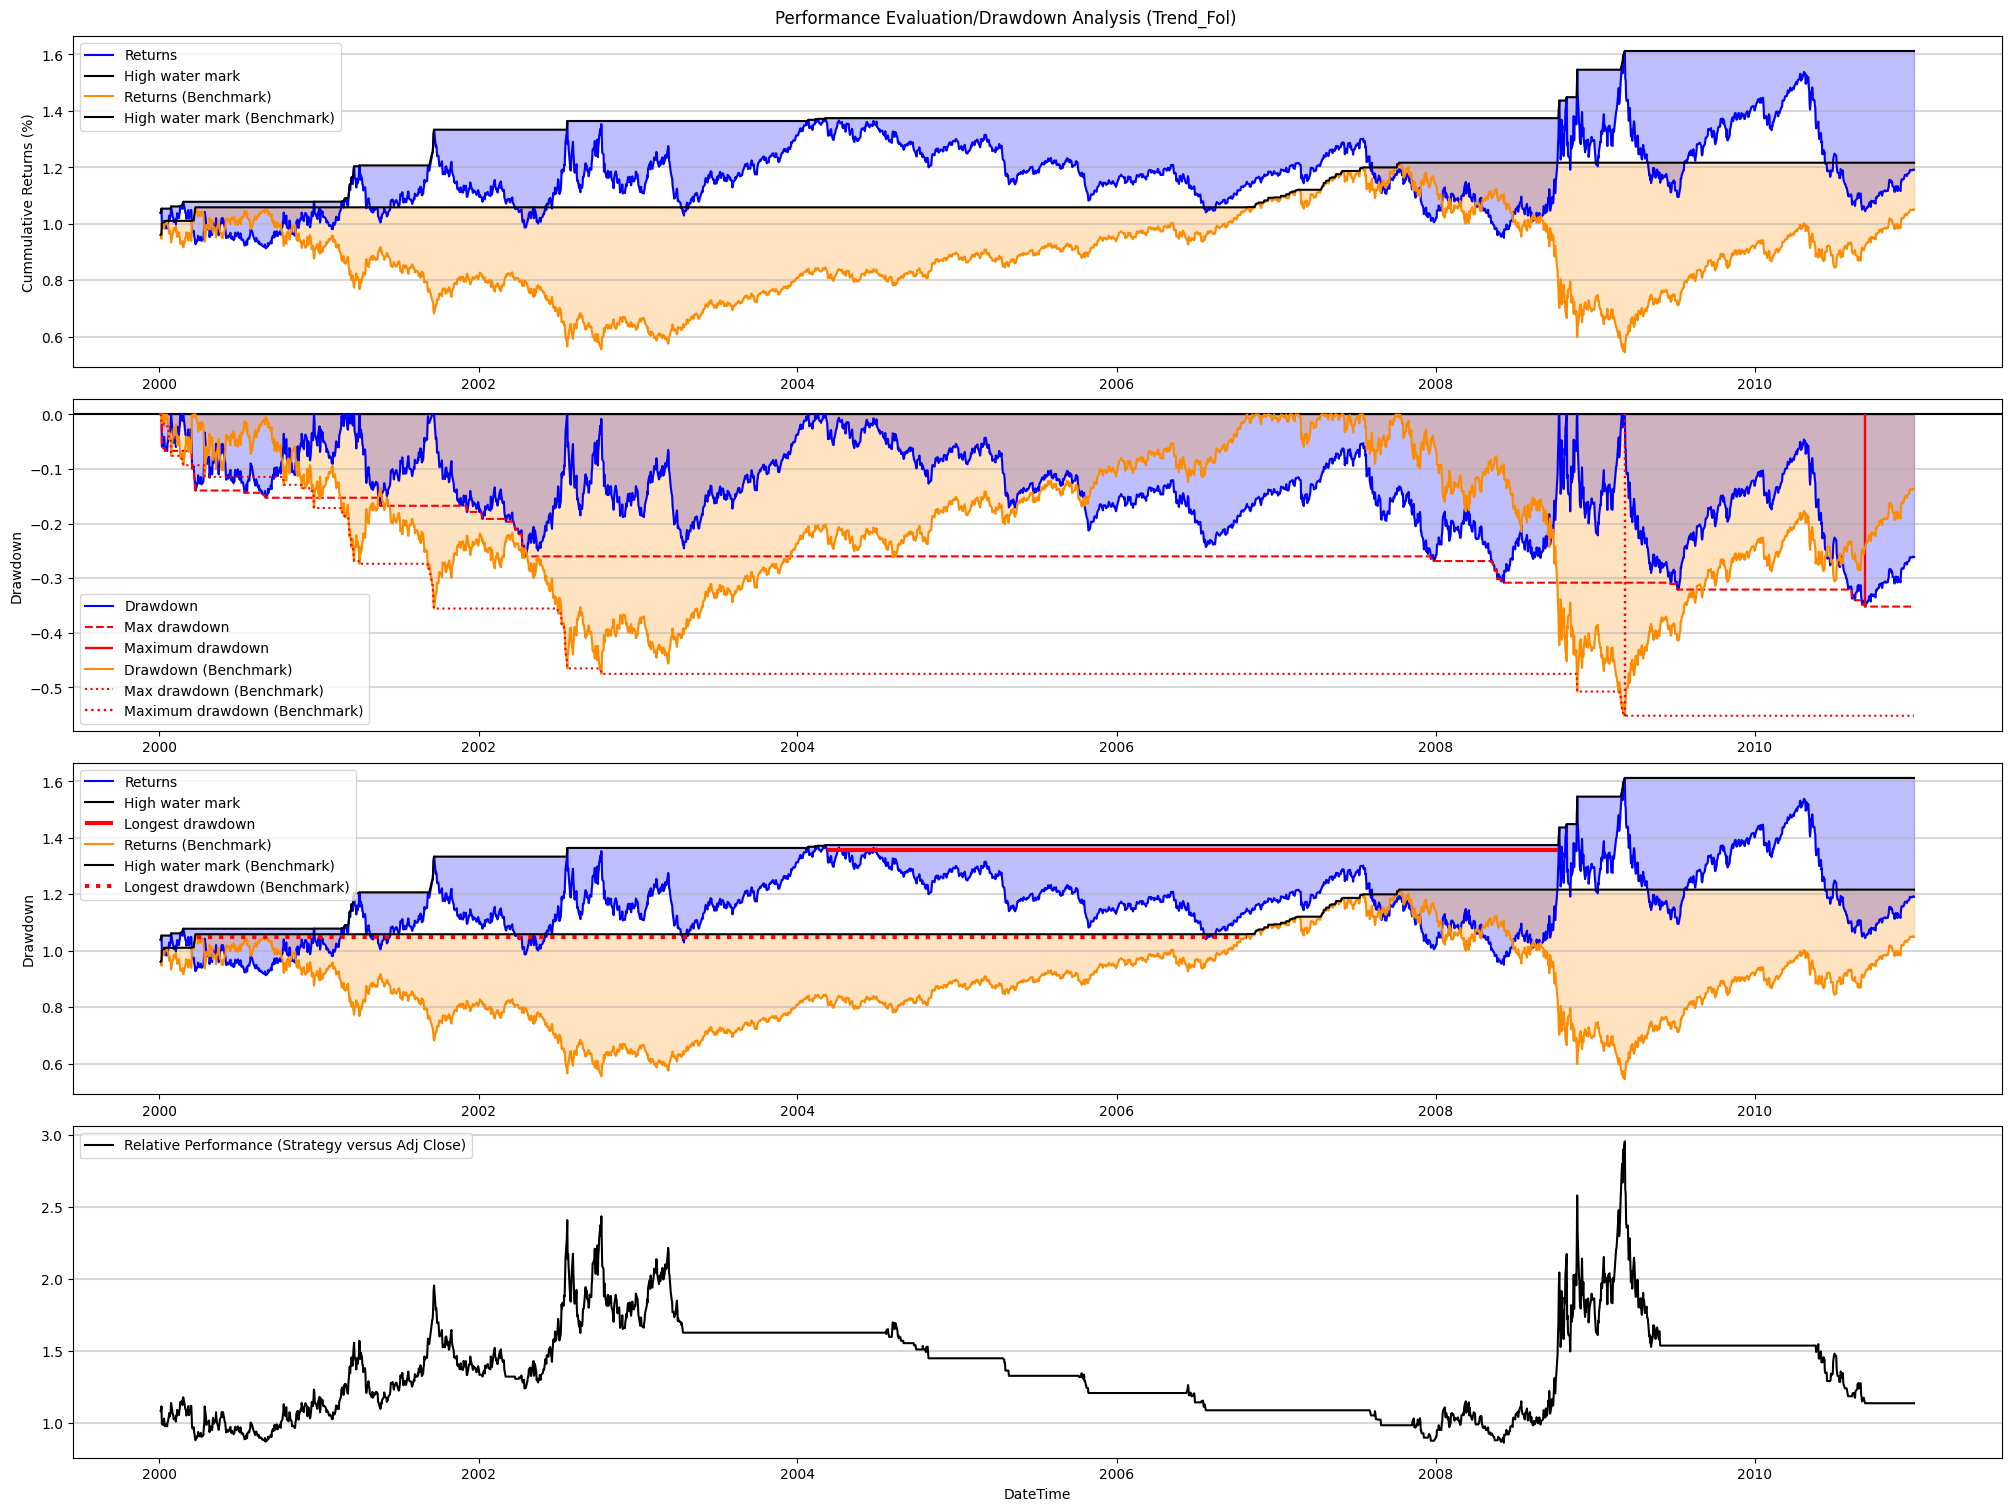

In [110]:
functions.drawdownCharts(trend_following_strat, trend_following_sig["Adj Close"].pct_change().dropna(), includeBenchmark=True, showPlot=True)

### Momentum

In [92]:
px_mom = functions.computeMomentum(pd.DataFrame(spy['Adj Close']), 1, "2000-01-03", end = "2010-12-31", asset_name = "SPY US Equity")
px_mom_3 = functions.computeMomentum(pd.DataFrame(spy['Adj Close']), 3, "2000-01-03", end = "2010-12-31", asset_name = "SPY US Equity")
px_mom_6 = functions.computeMomentum(pd.DataFrame(spy['Adj Close']), 6, "2000-01-03", end = "2010-12-31", asset_name = "SPY US Equity")

/Users/clarencetee/Desktop/Useful_Code_Repositories/Strategies/functions/functions.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_df_2 = all_df.join(df.Price).drop(['Price_full'], axis=1).fillna(method='ffill')
/Users/clarencetee/Desktop/Useful_Code_Repositories/Strategies/functions/functions.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_df_2 = all_df.join(df.Price).drop(['Price_full'], axis=1).fillna(method='ffill')
/Users/clarencetee/Desktop/Useful_Code_Repositories/Strategies/functions/functions.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_df_2 = all_df.join(df.Price).drop(['Price_full'], axis=1).fillna(method='ffill')


In [93]:
px_mom ['Signal'] = np.where(px_mom.Mth_Prior_1_Return >= 0, 1, 0)
px_mom_3['Signal'] = np.where(px_mom_3.Mth_Prior_3_Return >= 0, 1, 0)
px_mom_6['Signal'] = np.where(px_mom_6.Mth_Prior_6_Return >= 0, 1, 0)

sig_1_mo = px_mom.Signal
sig_1_mo.name = 'PX_Mom_1'
sig_3_mo = px_mom_3.Signal
sig_3_mo.name = 'PX_Mom_3'
sig_6_mo = px_mom_6.Signal
sig_6_mo.name = 'PX_Mom_6'

all_px_mom_sig = pd.concat([sig_1_mo, sig_3_mo, sig_6_mo], axis=1)
all_px_mom_sig['Sig_Strength'] = all_px_mom_sig.sum(axis=1)
all_px_mom_sig['Sig_Strength_Adj'] = all_px_mom_sig['Sig_Strength'].shift(1)
all_px_mom_sig['SPY_ret'] = spy['Adj Close'].pct_change()
all_px_mom_sig.dropna(inplace=True)
all_px_mom_sig['Positioning'] = all_px_mom_sig['Sig_Strength_Adj'].map({0 : 0.1, 1 : 0.4, 2 : 0.6, 3: 0.9})
all_px_mom_sig['Portfolio'] = all_px_mom_sig['Positioning'] * all_px_mom_sig['SPY_ret']
all_px_mom_sig

,PX_Mom_1,PX_Mom_3,PX_Mom_6,Sig_Strength,Sig_Strength_Adj,SPY_ret,Positioning,Portfolio
Date,,,,,,,,
2000-07-03,0,0.0,1.0,1.0,1.0,0.013766,0.4,0.005507
2000-07-05,0,0.0,1.0,1.0,1.0,-0.018035,0.4,-0.007214
2000-07-06,0,0.0,1.0,1.0,1.0,0.007779,0.4,0.003111
2000-07-07,1,0.0,1.0,2.0,1.0,0.016081,0.4,0.006432
2000-07-10,1,0.0,1.0,2.0,2.0,-0.001688,0.6,-0.001013
...,...,...,...,...,...,...,...,...
2010-12-27,1,1.0,1.0,3.0,3.0,0.000398,0.9,0.000358
2010-12-28,1,1.0,1.0,3.0,3.0,0.001432,0.9,0.001289
2010-12-29,1,1.0,1.0,3.0,3.0,0.000715,0.9,0.000644


In [94]:
functions.exportPerformanceMetrics(all_px_mom_sig["Portfolio"], all_px_mom_sig["SPY_ret"])

,Strategy,Benchmark
Performance Metrics (2000-07-03 till 2010-12-31),,
CAGR %,1.56%,0.43%
Volatility,9.03%,21.84%
Sharpe Ratio,0.17,0.02
Sortino Ratio,0.22,0.03
Max Drawdown %,-24.87%,-55.19%
Return/MaxDrawdown,0.06,0.01


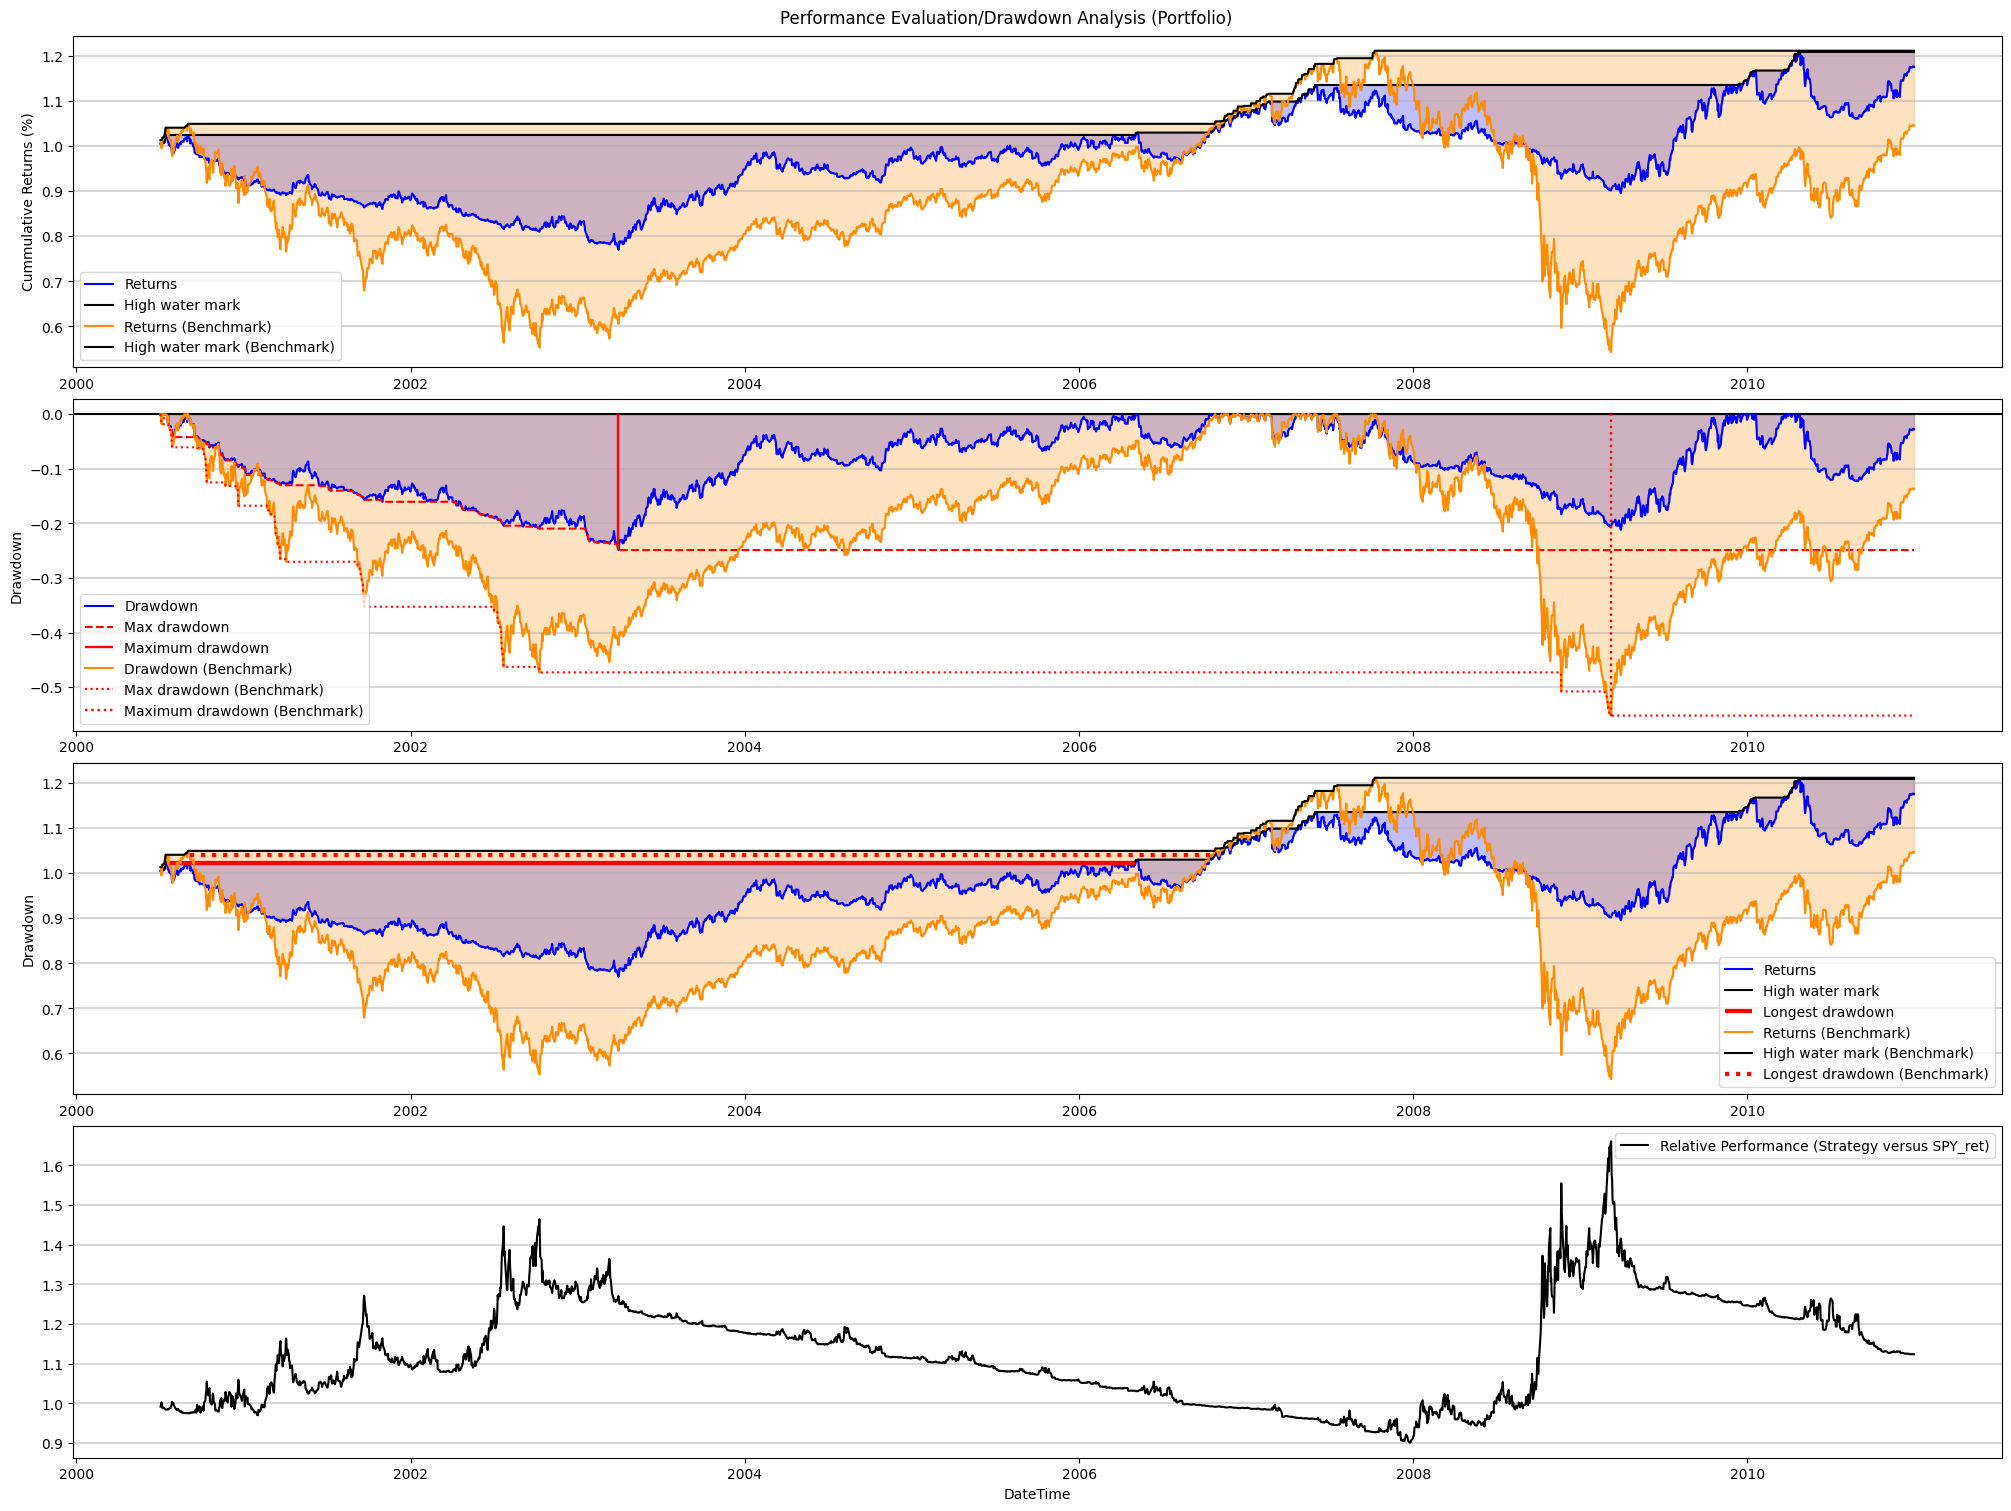

In [95]:
functions.drawdownCharts(all_px_mom_sig["Portfolio"], benchmark = all_px_mom_sig["SPY_ret"], includeBenchmark = True, showPlot=True)

In [70]:
nav_numbers = pd.read_excel("nav_sample.xlsx")
avm = nav_numbers[["Date_Strat", "AVM GOF A"]].dropna()
avm.rename(columns = {'Date_Strat':'Date'}, inplace=True)
avm.set_index('Date', inplace=True)
bnchmk = nav_numbers[["Date_Indx", "BHMACR Index Adj"]].dropna()
bnchmk.rename(columns = {'Date_Indx':'Date'}, inplace=True)
bnchmk.set_index('Date', inplace=True)

# Both strategy and benchmark have to share the same end of month.
avm = avm.resample('BM').last()
bnchmk = bnchmk.resample('BM').last()
nav_numbers

,Date_Strat,AVM GOF A,Date_Indx,BHMACR Index,BHMACR Return,BHMACR Index Adj,BHMACR Return Check
0,2016-10-31,100.00,2013-12-31,1000.00,NaN,NaN,NaN
1,2016-11-30,98.81,2014-01-31,989.10,-1.090000,NaN,NaN
2,2016-12-30,100.67,2014-02-28,1002.91,1.396219,NaN,NaN
3,2017-01-31,102.04,2014-03-31,993.89,-0.899383,NaN,NaN
4,2017-02-28,104.36,2014-04-30,994.63,0.074455,NaN,NaN
...,...,...,...,...,...,...,...
112,NaT,NaN,2023-04-28,1219.02,0.470613,117.328534,0.470613
113,NaT,NaN,2023-05-31,1214.66,-0.357664,116.908891,-0.357664
114,NaT,NaN,2023-06-30,1228.82,1.165758,118.271767,1.165758
115,NaT,NaN,2023-07-31,1238.48,0.786120,119.201525,0.786120


In [85]:
functions.exportPerformanceMetrics(avm['AVM GOF A'].pct_change().dropna(), bnchmk['BHMACR Index Adj'].pct_change().dropna(), freq='M')

,Strategy,Benchmark
Performance Metrics (2016-11-30 till 2023-08-31),,
CAGR %,8.70%,2.44%
Volatility,4.70%,4.74%
Sharpe Ratio,1.85,0.51
Sortino Ratio,2.22,0.84
Max Drawdown %,-7.89%,-9.21%
Return/MaxDrawdown,1.10,0.26


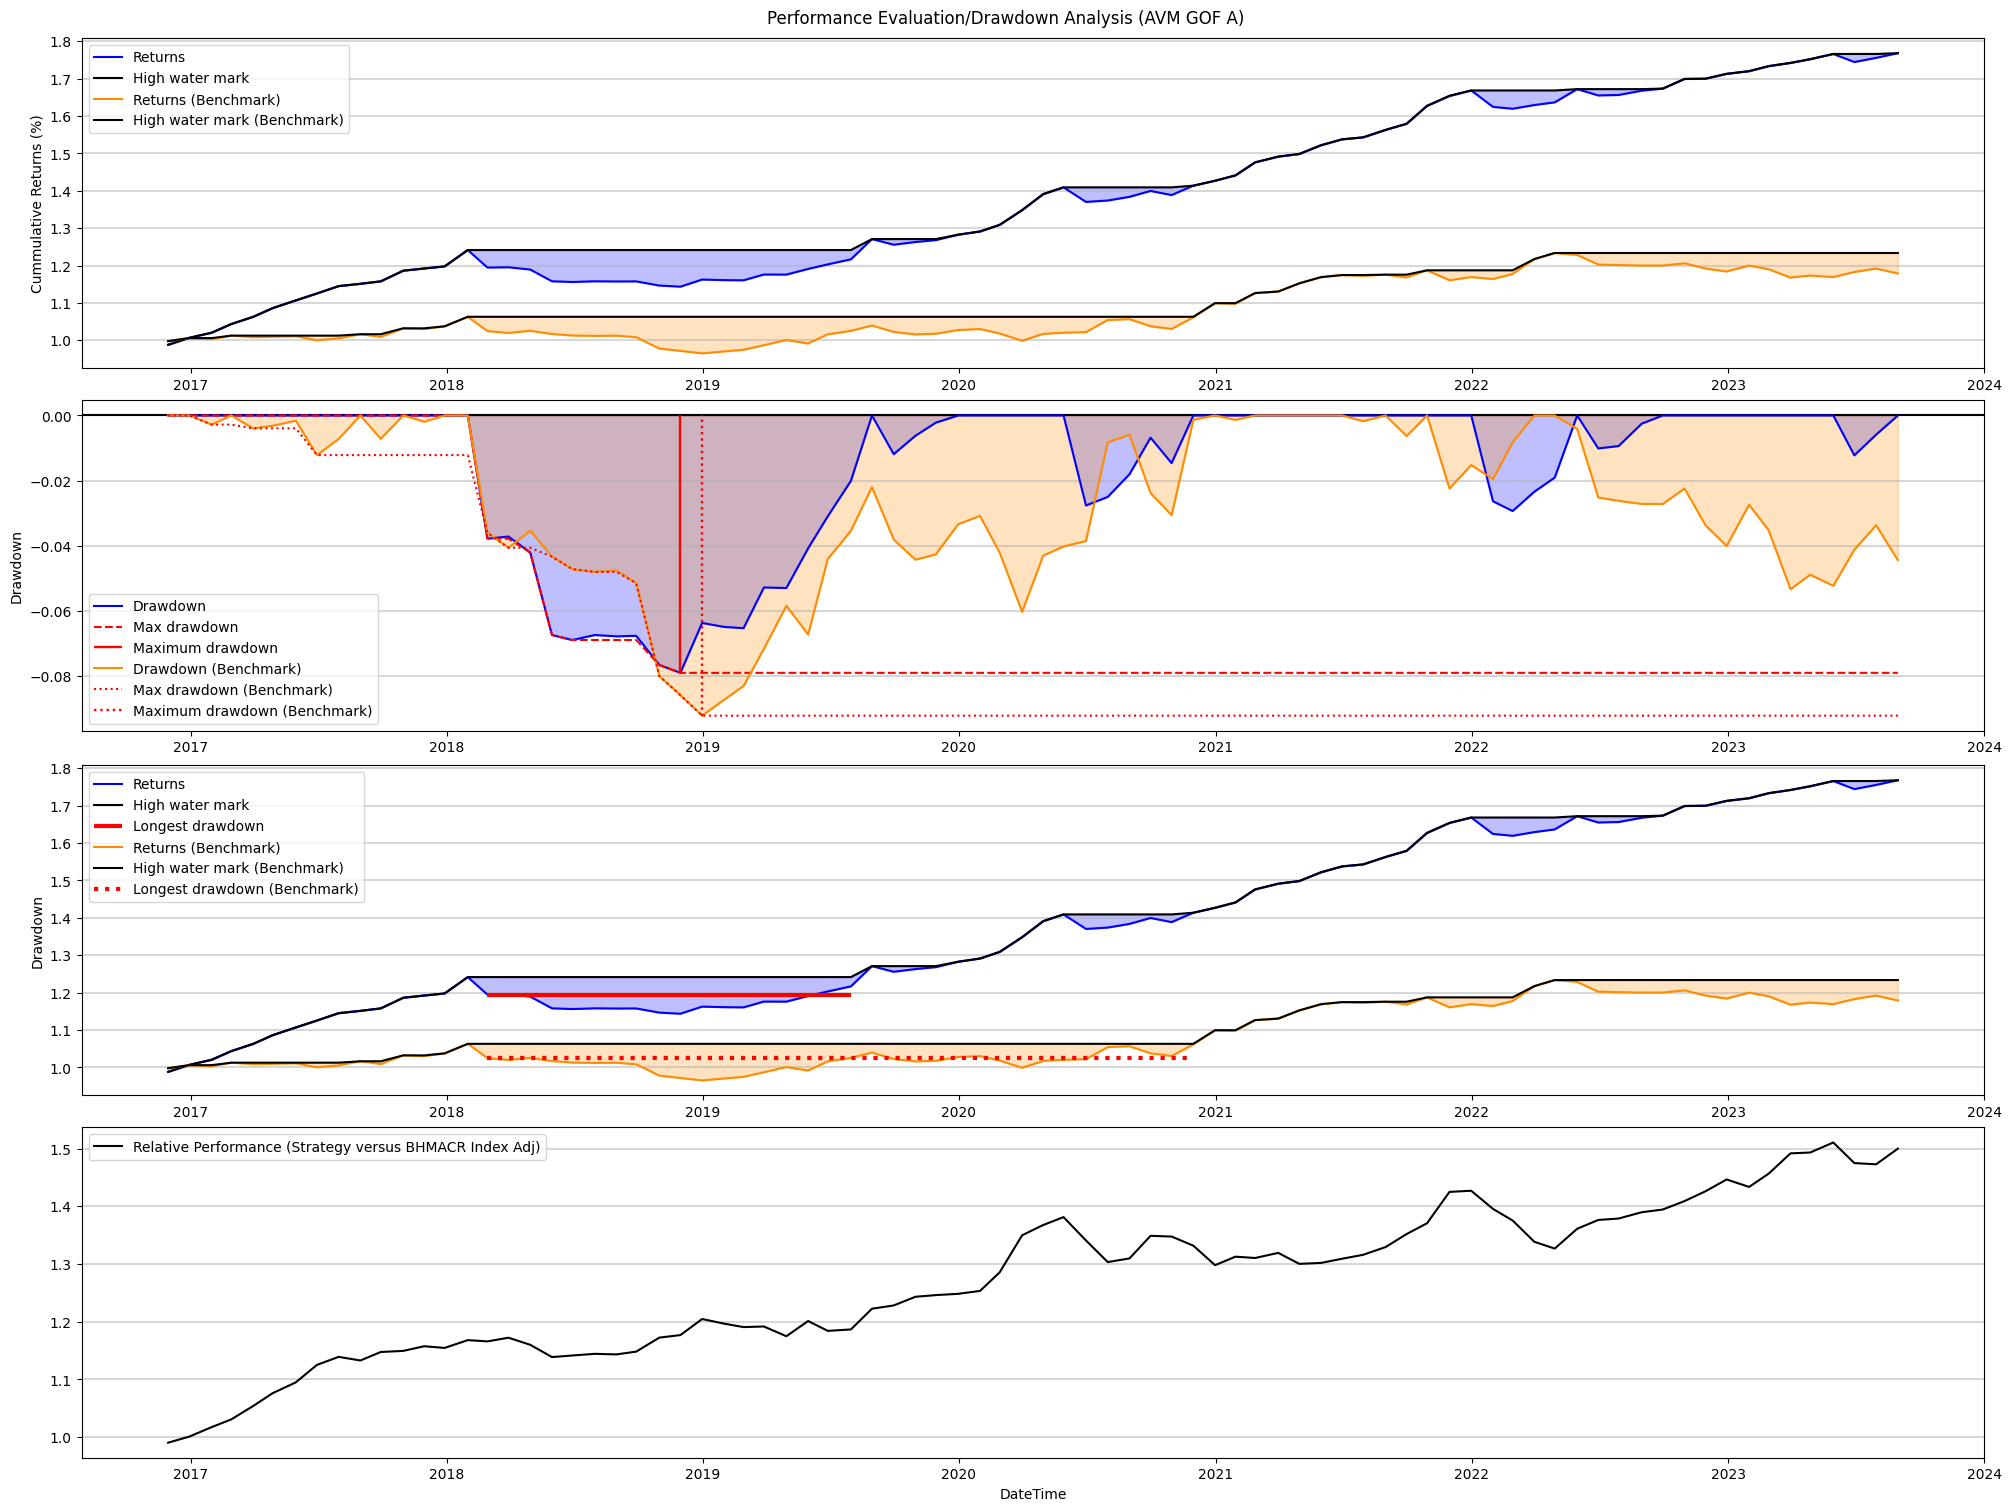

In [86]:
functions.drawdownCharts(avm['AVM GOF A'].pct_change(), bnchmk['BHMACR Index Adj'].pct_change(), includeBenchmark=True, showPlot=True)

### PCA for Term Structure Analysis